In [198]:
import re
import json
import pickle
import pandas as pd
import yaml

with open("../configs/run_pipline.yaml", 'r') as file:
        config = yaml.safe_load(file)

# Load pickle file
with open("E:/UT/Term8/LLM/LLMs-For-Rational-Trading/trader_results/model_responses.pkl", "rb") as f:   # "rb" = read binary
    model_responses = pickle.load(f)
with open("E:/UT/Term8/LLM/LLMs-For-Rational-Trading/trader_results/dates.pkl", "rb") as f:   # "rb" = read binary
    dates = pickle.load(f)

price_df = pd.read_csv("../" + config['paths']['evaluation'])

actions, explanations = [], []



for response in model_responses:
    match = re.search(r"\{.*\}", response, re.S)
    if match:
        json_str = match.group(0).strip()

        # 🔹 Clean common junk
        json_str = json_str.replace("```json", "").replace("```", "").strip()

        try:
            data = json.loads(json_str)
        except json.JSONDecodeError as e:
            print("JSON decode error:", e)
            print("Problematic string:", json_str)
            actions.append(2)                # default action
            explanations.append("")          # default explanation
            continue

        # 🔹 Extract fields safely
        action = data.get("action", 2)
        if isinstance(action, int):
            actions.append(action)
        elif isinstance(action, str):
            if "Buy" in action:
                actions.append(1)
            elif "Sell" in action:
                actions.append(0)
            else:
                actions.append(2)  # fallback
        else:
            actions.append(2)      # fallback

        explanations.append(data.get("explanation", ""))
    else:
        print("No JSON found")
        actions.append(2)           # default action
        explanations.append("")     # default explanation

JSON decode error: Expecting ',' delimiter: line 3 column 16 (char 316)
Problematic string: {
  "explanation": "Given the recent mixed technical signals and economic news indicating potential volatility in the gold market, continuing to hold a neutral position is advisable. The market sentiments driven by external news, especially in trade, suggest caution rather than aggressive trading.",
  "action": 2  // Neutral (Wait)
}


In [199]:
import pandas as pd
result_df = pd.DataFrame({
    'date': dates,
    'final_decision': actions
})


result_df = pd.merge(result_df, price_df[['date', 'open', 'close']], on='date', how='left')

In [ ]:
result_df

In [201]:
# import pickle
# import pandas as pd
# # Path to your pickle file/
# pickle_path = "E:/UT/Term8/LLM/LLMs-For-Rational-Trading/llm_results.csv"

# # Load the pickle file
# with open(pickle_path, "rb") as f:
#     df = pd.read_csv(f)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = result_df.dropna()
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")
df["day_of_week"] = df["date"].dt.day_name()
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"])

# Calculate daily profit/loss based on decision
def calc_profit(row):
    if row["final_decision"] == 0:  # sell
        return row["open"] - row["close"]
    elif row["final_decision"] ==  1:  # buy
        return row["close"] - row["open"]
    else:
        return 0

df["profit"] = df.apply(calc_profit, axis=1)

# Final total profit
final_profit = df["profit"].sum()
mean_profit = df["profit"].mean()
print(f"Final Total Profit: {final_profit}")
print(f"Final Mean Profit: {mean_profit}")

# Monthly profit & decision counts
monthly_stats = df.groupby("month").agg(
    total_profit=("profit", "sum"),
    decision_count=("final_decision", "count"),
    buy_count=("final_decision", lambda x: (x == 2).sum()),
    sell_count=("final_decision", lambda x: (x == 1).sum()),
    wait_count=("final_decision", lambda x: (x == 0).sum()),
)

# Weekday vs weekend profit & decision counts
week_part_stats = df.groupby("is_weekend").agg(
    total_profit=("profit", "sum"),
    decision_count=("final_decision", "count"),
    buy_count=("final_decision", lambda x: (x == 2).sum()),
    sell_count=("final_decision", lambda x: (x == 1).sum()),
    wait_count=("final_decision", lambda x: (x == 0).sum()),
)

# Day of week profit & decision counts
dow_stats = df.groupby("day_of_week").agg(
    total_profit=("profit", "sum"),
    decision_count=("final_decision", "count"),
    buy_count=("final_decision", lambda x: (x == 2).sum()),
    sell_count=("final_decision", lambda x: (x == 1).sum()),
    wait_count=("final_decision", lambda x: (x == 0).sum()),
)

print("/nMonthly Stats:/n", monthly_stats)
print("/nWeekday vs Weekend Stats:/n", week_part_stats)
print("/nDay of Week Stats:/n", dow_stats)


In [203]:
# Calculate counts of each decision
decision_counts = df["final_decision"].value_counts().sort_index()
buy_count = decision_counts.get(2, 0)
sell_count = decision_counts.get(1, 0)
wait_count = decision_counts.get(0, 0)

# Calculate total profit for each decision type
buy_profit = df.loc[df["final_decision"] == 2, "profit"].sum()
sell_profit = df.loc[df["final_decision"] == 1, "profit"].sum()
wait_profit = df.loc[df["final_decision"] == 0, "profit"].sum()

# Calculate total profit overall
total_profit = df["profit"].sum()

print(f"Buy decisions: {buy_count}, Total Buy Profit: {buy_profit}")
print(f"Sell decisions: {sell_count}, Total Sell Profit: {sell_profit}")
print(f"Wait decisions: {wait_count}, Total Wait Profit: {wait_profit}")
print(f"Overall Total Profit: {total_profit}")


Buy decisions: 53, Total Buy Profit: 0.0
Sell decisions: 17, Total Sell Profit: 116.100341796875
Wait decisions: 13, Total Wait Profit: -198.00048828125
Overall Total Profit: -81.900146484375


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection

plt.rcParams['text.usetex'] = False  # Disable LaTeX

df["date"] = pd.to_datetime(df["date"])
dates = mdates.date2num(df["date"])
profits = df["profit"].values

fig, ax = plt.subplots(figsize=(9, 4.5))

# Create segments for LineCollection
points = np.array([dates, profits]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Color segments red if either endpoint below zero, else green
colors = ['red' if (p0 < 0 or p1 < 0) else 'green' for p0, p1 in zip(profits[:-1], profits[1:])]

# Add colored line segments
lc = LineCollection(segments, colors=colors, linewidth=1.5)
ax.add_collection(lc)

# Seaborn scatter plot of points (black dots)
sns.scatterplot(data=df, x="date", y="profit", color='black', s=30, ax=ax, legend=False, zorder=5)

# Horizontal zero line
# ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Date ticks formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Profit per Trade (USD)")

# ax.set_xlim(dates.min(), dates.max())
# ax.set_ylim(profits.min() * 1.1, profits.max() * 1.1)

plt.tight_layout()
plt.show()

print(f"Number of samples plotted: {len(df)}")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27160\2873619893.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27160\2873619893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cumulative_profit"] = np.cumsum(df["profit"])


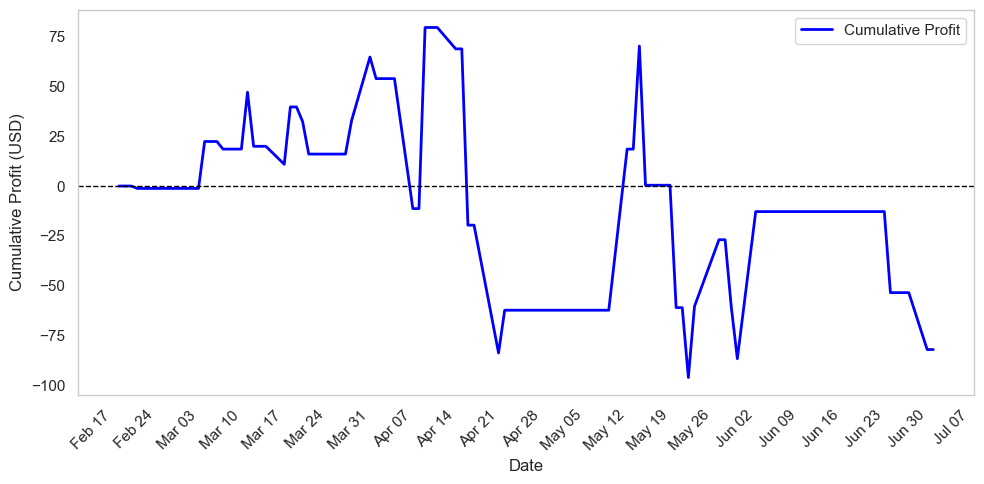

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Assuming df is your DataFrame and already has 'date' and 'profit' columns
df["date"] = pd.to_datetime(df["date"])
df["cumulative_profit"] = np.cumsum(df["profit"])

sns.set(style="whitegrid")  # You can choose other seaborn styles

fig, ax = plt.subplots(figsize=(10, 5))

# Plot cumulative profit with seaborn lineplot
sns.lineplot(data=df, x="date", y="cumulative_profit", ax=ax, color='blue', linewidth=2, label='Cumulative Profit')

# Horizontal line at y=0 (like your dashed line)
ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Cumulative Profit (USD)", fontsize=12)

# Formatting x-axis date ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Remove grid if you want (or keep it if you like seaborn grid)
ax.grid(False)

# Show axis spines with linewidth 1
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)

# Remove top and right ticks
ax.tick_params(top=False, right=False)

plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27160\223580023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27160\223580023.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_profit = df.groupby(pd.Grouper(key='date', freq='M'))['profit'].sum()


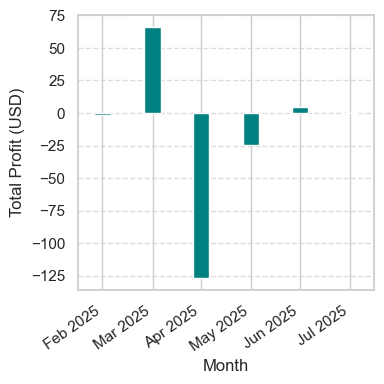

In [206]:
import matplotlib.pyplot as plt
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
monthly_profit = df.groupby(pd.Grouper(key='date', freq='M'))['profit'].sum()

fig, ax = plt.subplots(figsize=(4, 4))

# Plot using datetime index directly
ax.bar(monthly_profit.index, monthly_profit.values, color='teal', width=10)  # width in days

# Format x-axis
ax.set_xticks(monthly_profit.index)
ax.set_xticklabels(
    [d.strftime('%b %Y') for d in monthly_profit.index],
    rotation=35,
    ha='right'
)

ax.set_xlabel('Month')
ax.set_ylabel('Total Profit (USD)')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tighten x-axis limits so bars fill more space
ax.set_xlim(monthly_profit.index.min() - pd.Timedelta(days=15),
            monthly_profit.index.max() + pd.Timedelta(days=15))

plt.tight_layout()
plt.show()


In [207]:
S

NameError: name 'S' is not defined